In the previous notebook we prepared and massaged our text into input vectors that encode both tokens as well as their positions.  It's these input vectors that will be handled by the rest of the model.

# Self-Attention



Self-Attention is a technique whereby each position in the input sequence can consider the relevancy of each other position in the same sequence when the representation for the sequence is being computed.  (Traditional "attention", as opposed to self-attention look at relations between two different sequences, input- and output, as opposed as using a single sequence.)

## Simplified Self-Attention

Let's take a simple sentence:
"I am learning this"

This is our input sequencen let's call it $x$ with 4 tokens: $x^{(1)}$, $x^{(2)}$, $x^{(3)}$ and $x^{(4)}$.

In general if our context length is $T$ then we have $x^{(1)} \ldots x^{(T)}$

Each $x^{(i)}$ is a $d$-dimensional embedding vector representing a token.

Now we will calculate a context vector $z^{i}$ for each $x^{i}$.  This vector will contain information from all vectors $x^{(1)} \ldots x^{(T)}$

### Attention scores

So, for example, for $x^{(3)}$ we'll calculate a context vector $z^{(3)}$.  We'll call $x^{(3)}$ our "query" vector and for this query we'll calculate an attention score for each of the tokens in our sentence: for example $w_{31}$ for the attention score between our query (the 3rd token) and the first token.  In this way we'll have: $w_{31}$, $w_{32}$, $w_{33}$ and $w_{34}$

The attention score $w_{31}$ is the dot product from the third token with the first token.  So if:
$$ x^{(3)} = [0.2,0.7,0.9] \text{  (representing the token "learning")} $$
$$ x^{(1)} = [0.8,0.9,0.3] \text{  (representing the token "I")} $$

Then:

$$w_{(31)} = x^{(3)} \cdot x^{(1)} = [(.2*.8) + (.7*.9) + (.9 * .3)] = 1.06 $$

We'll do this between our query $x^{(3)}$ and each of our $x^{(1)},x^{(2)},x^{(3)},x^{(4)}$ which result in an attention vector $w_3 = [ w_{(31)},w_{(32)},w_{(33)},w_{(34)} ]$

Now in python, using an input vector of our 4 tokens, each with an embedding dimension of 3:

In [59]:
#|echo: false
import torch
torch.manual_seed(42)

embedding_dim = 3
inputs = torch.rand((4,embedding_dim))
print(inputs)

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408],
        [0.1332, 0.9346, 0.5936]])


We'll calculate the attention vector for $x^{(3)}$ as our query:

In [60]:
query = inputs[2]
attention_score_for_x3 = torch.empty((4))
for i, xi in enumerate(inputs):
    # Calculate the attention score for x3i
    attention_score_for_x3[i] = torch.dot(xi, query)

print(attention_score_for_x3)

tensor([1.3127, 1.1213, 1.5807, 1.3343])


### Normalizing

Now that we've calculated the attention vector $w_3$ for query $x^{(3)}$, we have a vector with a number for every token.  These numbers however are not normalized between $0$ and $1$, which is what we'd really like.  For this, we'll use [Cross-Entropy Loss](../theory/cross-entropy-loss.ipynb), which will make sure the numbers in our attention vector add up to one and each are between $0 \ldots 1$

In [61]:
attention_weights_for_x3 = torch.softmax(attention_score_for_x3, dim=0)
print(attention_weights_for_x3)

tensor([0.2407, 0.1987, 0.3146, 0.2459])


### Context Vector

So now that we have our normalized attention weights for a single query $x^{(3)}$ we can calculate the full context vector that corresponds to $x^{(3)}$

Our attention weights from the previous step were: $[.2, .1, .3, .2]$ or more in general, a vector $[\alpha _{31}, \alpha _{32}, \alpha _{33}, \alpha _{34}]$

To calculate the context vector for $x^{(3)}$ we'll take each $\alpha _{3i}$ and multiply that by $x^{(i)}$.  Then we'll add up all those vectors.

In [62]:
query = inputs[2]
context_vector_for_x3 = torch.zeros((query.shape)) # dimension of query (3 in this case)

for i, xi in enumerate(inputs):
    context_vector_for_x3 += attention_weights_for_x3[i] * xi # z3

print(context_vector_for_x3)

tensor([0.5165, 0.7774, 0.6536])


### All context vectors

What we did so far is to look at how to calculate a single context vector $z^{(3)}$, for a single token $x^{(3)}$ in our input sequence.  We'll need to make this more scalable and figure out a way to calculate $z$ for all tokens in our input sequence.

This means, what we have done for $x^{(3)}$ we need to do for all inputs:

In [63]:
attention_scores_manual = torch.empty((4, 4))  # for each query of the 4 inputs, calculate 4 attention scores
for i, query in enumerate(inputs):
    for j, xi in enumerate(inputs):
        attention_scores_manual[i][j] = torch.dot(query, xi)

print("attention scores:")
print(attention_scores_manual)
print("for comparison, the attention scores for x3 as query:")
print(attention_score_for_x3)

attention scores:
tensor([[1.7622, 1.4337, 1.3127, 1.1999],
        [1.4337, 1.4338, 1.1213, 0.8494],
        [1.3127, 1.1213, 1.5807, 1.3343],
        [1.1999, 0.8494, 1.3343, 1.2435]])
for comparison, the attention scores for x3 as query:
tensor([1.3127, 1.1213, 1.5807, 1.3343])


Using `for` loops however is slow and can't be optimized using CUDA, so let's find a way to do the same, but to use pure tensor calculations instead.  Our inputs look like the below, with 4 tokens, each with a dimension of 3

In [64]:
#| echo: false
print(inputs)

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408],
        [0.1332, 0.9346, 0.5936]])


We can transpose this vector, so it looks like:

In [65]:
#| echo: false
print(inputs.T)

tensor([[0.8823, 0.9593, 0.2566, 0.1332],
        [0.9150, 0.3904, 0.7936, 0.9346],
        [0.3829, 0.6009, 0.9408, 0.5936]])


If we now take multiply these two matrices, we get:

In [66]:
attention_scores = inputs @ inputs.T  # matrix multiplication
print(inputs @ inputs.T) # matrix multiplication
print("for comparison, the attention scores for x3 as query:")
print(attention_score_for_x3)

tensor([[1.7622, 1.4337, 1.3127, 1.1999],
        [1.4337, 1.4338, 1.1213, 0.8494],
        [1.3127, 1.1213, 1.5807, 1.3343],
        [1.1999, 0.8494, 1.3343, 1.2435]])
for comparison, the attention scores for x3 as query:
tensor([1.3127, 1.1213, 1.5807, 1.3343])


These are just attention scores, not yet attention weights, so lets normalize them:

In [67]:
attention_weights = torch.softmax(attention_scores, dim=-1)  # normalize the attention scores
print("attention weights:")
print(attention_weights)
print("for comparison, the attention weights for x3 as query:")
print(attention_weights_for_x3)

attention weights:
tensor([[0.3415, 0.2459, 0.2179, 0.1946],
        [0.3040, 0.3040, 0.2225, 0.1695],
        [0.2407, 0.1987, 0.3146, 0.2459],
        [0.2569, 0.1809, 0.2938, 0.2683]])
for comparison, the attention weights for x3 as query:
tensor([0.2407, 0.1987, 0.3146, 0.2459])


From here we can calculate our context vectors:

In [68]:
all_context_vectors = attention_weights @ inputs  # matrix multiplication
print("context vectors for all inputs:")
print(all_context_vectors)
print("for comparison, the context vector for x3:")
print(context_vector_for_x3)

context vectors for all inputs:
tensor([[0.6191, 0.7634, 0.5991],
        [0.6395, 0.7318, 0.6090],
        [0.5165, 0.7774, 0.6536],
        [0.5113, 0.7897, 0.6428]])
for comparison, the context vector for x3:
tensor([0.5165, 0.7774, 0.6536])


## Self-Attention with trainable weights

From here we'll expand to what is called "scaled dot-product attention".  Also here we'll want to calculate context vectors (one for each of our input tokens) as a weighted sum over (some abstraction) of the inputs.  There are some differences with what we've done so far though:

- instead of taking directly $q^{(i)} = x^{(i)}$ as the query vector, we'll use a projection of $x^{(i)}$.  We do this using a trainable weight matrix $W_q$, used to calculate our query
- instead of taking directly the dot product of $q^{(i)}$ and each $x^{(i)}$ to calculate our attention scores and weights, we'll do the dot product with a projection of $x^{(i)}$.  We do this using a trainable weight matrix $W_k$, used to calculate our keys.
- instead of calculating the weighted average using these scores with each $x^{(i)}$, we'll do this with a projection of $x^{(i)}$.  We do this using a trainable weight matrix $W_v$, used to calculate our values.

We'll have trainable weight matrixes: $W_q$, $W_k$, $W_v$ so that the model, when trained can learn to use these to project respectively the query, key and value vectors.

### Single context vector (1)

Our token embedding vectors are of a certain dimension `embedding_dim = 3` in our example.  We can choose to project these into another dimension, from 3 to 5 for example.  (This is not usually done however, it's likely kept the same.)  For illustration purposes, let's go with 5 here:

In [69]:
torch.manual_seed(42)  # for reproducibility

d_in = embedding_dim
d_out = 2

W_query_1 = torch.rand((d_in, d_out))
W_key_1 = torch.rand((d_in, d_out))
W_value_1 = torch.rand((d_in, d_out))

We can now use  $W_q$, $W_k$, $W_v$ to project an embedding vector from it's normal dimension into a dimension of 5.  Let's use $x^{(3)}$ as an example for our query:

In [70]:
x3 = inputs[2]
print("x3 input:")
print(x3)

print("W_query:")
print(W_query_1)

query = x3 @ W_query_1
print("projected query:")
print(query)

x3 input:
tensor([0.2566, 0.7936, 0.9408])
W_query:
tensor([[0.8823, 0.9150],
        [0.3829, 0.9593],
        [0.3904, 0.6009]])
projected query:
tensor([0.8975, 1.5614])


Instead of defining our projection matrices like above, we'll define them as pytorch parameters:

In [71]:
W_query = torch.nn.Parameter(W_query_1, requires_grad=False)
W_key = torch.nn.Parameter(W_key_1, requires_grad=False)
W_value = torch.nn.Parameter(W_value_1, requires_grad=False)


Let's calculate our key and value vectors for every input token in our sentence "I am learning this": $x^{(1)}$: "I", $x^{(2)}$: "am", $x^{(3)}$: "learning", $x^{(4)}$: "this", 

In [72]:
values = inputs @ W_value
print("values:")
print(values)
keys = inputs @ W_key
print("keys:")
print(keys)

values:
tensor([[1.7842, 1.1135],
        [1.6554, 1.0571],
        [1.6442, 1.0264],
        [1.3340, 0.8176]])
keys:
tensor([[1.4450, 1.0493],
        [1.1750, 1.1700],
        [1.6917, 0.8678],
        [1.4682, 0.5825]])


Now we can calculate the attention scores, for our query vector that got projected from $x^{(3)}$

In [73]:
#| echo: false
print("query projection from x3:")
print(query)

query projection from x3:
tensor([0.8975, 1.5614])


The attention score $w_{31}$ is:

In [74]:
x1 = inputs[0]
print("x1 input:")
print(x1)
print("key projection from x1: ")
key = x1 @ W_key
print(key)
print("... which is the same as: ")
print(keys[0])  # keys[0] is the key for x1

print("attention score between our query and x1's projected key:")
attention_score_x3_x1 = query.dot(key)
print(attention_score_x3_x1)

x1 input:
tensor([0.8823, 0.9150, 0.3829])
key projection from x1: 
tensor([1.4450, 1.0493])
... which is the same as: 
tensor([1.4450, 1.0493])
attention score between our query and x1's projected key:
tensor(2.9354)


In the same way as we got the attention score between the query and x1, we can get all attention scores for our query like this:

In [75]:
attention_scores_x3_as_query = query @ keys.T
print("attention scores for x3 as query:")
print(attention_scores_x3_as_query)

attention scores for x3 as query:
tensor([2.9354, 2.8816, 2.8733, 2.2273])


As is shown above, for our chosen query, we'll end up with 4 attention scores: one for each input token.  Like before, we'll want to normalize our attention scores into attention weights but instead of doing a pure softmax function, we'll first scale the attention scores by dividing them by the square root of the dimension of our projected keys (2 in this case).

In [76]:
print("dimension of our projected key: ", d_out)
scaled_attention_weights_x3_as_query = \
  torch.softmax(attention_scores_x3_as_query / d_out**0.5, dim=-1)
print("scaled attention weights for x3 as query:")
print(scaled_attention_weights_x3_as_query)

dimension of our projected key:  2
scaled attention weights for x3 as query:
tensor([0.2836, 0.2730, 0.2714, 0.1719])


We don't have our full context vector yet.  For that we'll still need to make a weighted combination of our projected value vectors.  Before we do so, let's digress a little on the need for scaling the softmax.

### Why scaling?

As the dimension for our projected key vector grows, the dot products can become large numbers.  An example:

In [77]:
key_dim = 3
print("dimension of the key: ", key_dim)
small_proj_key_dim = 2
large_proj_key_dim = 64

test_token_embeddings = torch.rand((4, key_dim)) # 4 tokens, each with key_dim features
print("test token embeddings for 4 token:")
print(test_token_embeddings)

test_query  = test_token_embeddings[2]  # let's take the 3rd token as query
print("test query:")
print(test_query)

W_k_for_small_output_dim = torch.rand(key_dim, small_proj_key_dim)
W_q_for_small_output_dim = torch.rand(key_dim, small_proj_key_dim)
W_k_for_large_output_dim = torch.rand(key_dim, large_proj_key_dim)
W_q_for_large_output_dim = torch.rand(key_dim, large_proj_key_dim)

projected_small_keys = test_token_embeddings @ W_k_for_small_output_dim
projected_small_query = test_query @ W_q_for_small_output_dim
projected_large_keys = test_token_embeddings @ W_k_for_large_output_dim
projected_large_query = test_query @ W_q_for_large_output_dim

print("projected small query:")
print(projected_small_query)
print("projected small keys:")
print(projected_small_keys)
print("projected large query:")
print(projected_large_query)
print("projected large keys:")
print(projected_large_keys)

dimension of the key:  3
test token embeddings for 4 token:
tensor([[0.2666, 0.6274, 0.2696],
        [0.4414, 0.2969, 0.8317],
        [0.1053, 0.2695, 0.3588],
        [0.1994, 0.5472, 0.0062]])
test query:
tensor([0.1053, 0.2695, 0.3588])
projected small query:
tensor([0.4380, 0.3182])
projected small keys:
tensor([[0.9006, 0.6041],
        [0.9639, 0.8792],
        [0.4601, 0.4554],
        [0.6766, 0.3391]])
projected large query:
tensor([0.1878, 0.3446, 0.4501, 0.3379, 0.3108, 0.1170, 0.1112, 0.4571, 0.4659,
        0.4757, 0.2060, 0.3174, 0.3258, 0.3598, 0.2669, 0.5505, 0.6264, 0.1989,
        0.5678, 0.3476, 0.3972, 0.4965, 0.3051, 0.4656, 0.3402, 0.3913, 0.4238,
        0.1793, 0.2759, 0.1342, 0.4060, 0.4709, 0.5078, 0.2881, 0.1066, 0.2342,
        0.5123, 0.1315, 0.3327, 0.5920, 0.3685, 0.3478, 0.2677, 0.1843, 0.1589,
        0.1085, 0.1547, 0.3190, 0.4401, 0.2056, 0.4259, 0.4452, 0.4818, 0.3970,
        0.4401, 0.4995, 0.1077, 0.2400, 0.3922, 0.2375, 0.1725, 0.5728, 0.4268,


In [78]:
attention_scores_for_small_keys = projected_small_query @ projected_small_keys.T
print("attention scores for small keys:")
print(attention_scores_for_small_keys)
attention_scores_for_large_keys = projected_large_query @ projected_large_keys.T
print("attention scores for large keys:")
print(attention_scores_for_large_keys)

attention scores for small keys:
tensor([0.5867, 0.7019, 0.3464, 0.4042])
attention scores for large keys:
tensor([11.8494, 16.6880,  7.7068,  7.4401])


See how the attention score for a large projected key dimension is so much larger?  Let's see what happens if we just apply softmax to both the small and the large key:

In [79]:
attention_weights_for_small_keys = torch.softmax(attention_scores_for_small_keys, dim=0)
print("attention weights for small keys:")
print(attention_weights_for_small_keys)
attention_weights_for_large_keys = torch.softmax(attention_scores_for_large_keys, dim=0)
print("attention weights for large keys:")
print(attention_weights_for_large_keys)

attention weights for small keys:
tensor([0.2673, 0.2999, 0.2102, 0.2227])
attention weights for large keys:
tensor([7.8542e-03, 9.9193e-01, 1.2473e-04, 9.5529e-05])


If we now scale these values before applying softmax, we'll get a different output that brings the result for a large projected key vector much closer in range compared to the small projected key:

In [80]:
scaled_att_weights_for_small_keys = \
  torch.softmax(attention_scores_for_small_keys / small_proj_key_dim**0.5, dim=0)
print("scaled attention weights for small keys:")
print(scaled_att_weights_for_small_keys)
scaled_att_weights_for_large_keys = \
  torch.softmax(attention_scores_for_large_keys / large_proj_key_dim**0.5, dim=0)
print("scaled attention weights for large keys:")
print(scaled_att_weights_for_large_keys)

scaled attention weights for small keys:
tensor([0.2626, 0.2849, 0.2216, 0.2308])
scaled attention weights for large keys:
tensor([0.2498, 0.4574, 0.1488, 0.1440])


### Single context vector (2)

Now that we have our scaled attention weights, we can calculate the context vector for our query.  We'll do this by making a weighted combination of the projected values.  Our scaled attention weights were:

In [81]:
#| echo: false
print("scaled attention weights, one for each token:")
print(scaled_attention_weights_x3_as_query)

scaled attention weights, one for each token:
tensor([0.2836, 0.2730, 0.2714, 0.1719])


These we'll multiply with our projected values.  Our values were:

In [82]:
#| echo: false
print("projected values:")
print(values)

projected values:
tensor([[1.7842, 1.1135],
        [1.6554, 1.0571],
        [1.6442, 1.0264],
        [1.3340, 0.8176]])


The calculated attention vector $z^{(3)}$ for query from $x^{(3)}$:

In [83]:
context_vector_x3 = scaled_attention_weights_x3_as_query @ values
print("z3, the context vector for x3:")
print(context_vector_x3)
print("double check: the first number is the same as:")
print(0.2773*0.6307+0.2594*0.5699+0.27*0.8266+0.1933*0.6742)
print("the second number is the same as:")
print(0.2773*0.4225+0.2594*0.3401+0.27*0.2332+0.1933*0.2259)


z3, the context vector for x3:
tensor([1.6336, 1.0236])
double check: the first number is the same as:
0.67623003
the second number is the same as:
0.31201166


### All context vectors

Given everything we know now from above, we'll create a torch module for self attention now:

In [84]:
import torch.nn as nn
torch.manual_seed(42)  # for reproducibility

class SelfAttention_1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))
    
    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attention_scores = queries @ keys.T
        scaled_attention_weights = \
            torch.softmax(
                attention_scores / keys.shape[-1]**0.5
            , dim=-1)
        context_vectors = scaled_attention_weights @ values
        return context_vectors

The way we can use this module using our same inputs as before:

In [85]:
torch.manual_seed(42)  # for reproducibility

print("inputs: ")
print(inputs)
print("d_in:", d_in, "d_out:", d_out)

self_att = SelfAttention_1(d_in, d_out)
context_vectors_1 = self_att(inputs)
print("context vectors from SelfAttention v1:")
print(context_vectors_1)
print("for comparison, the context vector for x3:")
print(context_vector_x3)

inputs: 
tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408],
        [0.1332, 0.9346, 0.5936]])
d_in: 3 d_out: 2
context vectors from SelfAttention v1:
tensor([[1.6390, 1.0270],
        [1.6341, 1.0235],
        [1.6336, 1.0236],
        [1.6307, 1.0217]], grad_fn=<MmBackward0>)
for comparison, the context vector for x3:
tensor([1.6336, 1.0236])


In [86]:
torch.manual_seed(42)  # for reproducibility
from utils import plot_attention_heatmap

class SelfAttention_2(nn.Module):
    def __init__(self, d_in, d_out, kqv_bias=False, plot_att_weights=False):
        super().__init__()
        self.plot_att_weights = plot_att_weights
        self.W_query = nn.Linear(d_in, d_out, bias=kqv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=kqv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=kqv_bias)
    
    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attention_scores = queries @ keys.T
        scaled_attention_weights = \
            torch.softmax(
                attention_scores / keys.shape[-1]**0.5
            , dim=-1)
        
        if self.plot_att_weights:
            plot_attention_heatmap(scaled_attention_weights, ["I", "am", "learning", "this"])
        
        context_vectors = scaled_attention_weights @ values
        return context_vectors

inputs: 
tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408],
        [0.1332, 0.9346, 0.5936]])
d_in: 3 d_out: 2


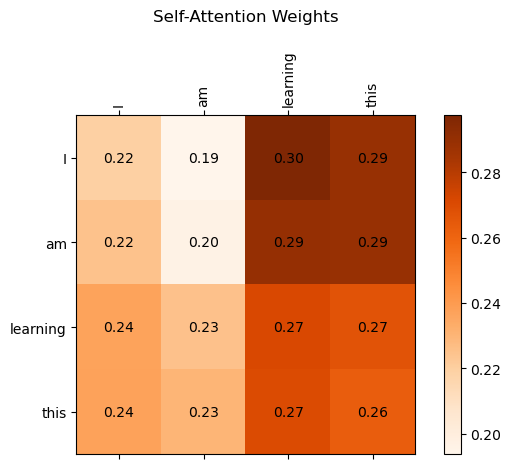

context vectors from SelfAttention v2:
tensor([[0.4536, 0.3638],
        [0.4547, 0.3629],
        [0.4642, 0.3538],
        [0.4657, 0.3523]], grad_fn=<MmBackward0>)


In [87]:
torch.manual_seed(42)  # for reproducibility

print("inputs: ")
print(inputs)
print("d_in:", d_in, "d_out:", d_out)

self_att = SelfAttention_2(d_in, d_out, kqv_bias=False, plot_att_weights=True)
context_vectors_2 = self_att(inputs)
print("context vectors from SelfAttention v2:")
print(context_vectors_2)

Note how the above result is different from our previous implementation, given a different strategy of initializing the weights for our linear layer.

## Causal self-attention

At this point, we had every token attend to every other token.  We need to introduce causality, making sure that when predicting the next token, the tokens before the current input cannot attend tokens that come after the current input.  (After all, these still need to be predicted.)  We'll do this using what is called "masked attention".

### Naive self-attention

First we'll set up the masking in a more naive way, not optimizing this yet just.  Let's first go back to calculating our queries, keys and attention scores.  As a reminder: our inputs and $W_q$, $W_{key}$ vectors:

In [88]:
#| echo: false
print(f"inputs: {inputs}")
print(f"inputs dimension: {inputs.shape} \n")
print(f"W_query weights: {self_att.W_query.weight}")
print(f"W_query dimension: {self_att.W_query.weight.shape} \n")
print(f"W_key weights: {self_att.W_key.weight}")
print(f"W_key dimension: {self_att.W_key.weight.shape} \n")

inputs: tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408],
        [0.1332, 0.9346, 0.5936]])
inputs dimension: torch.Size([4, 3]) 

W_query weights: Parameter containing:
tensor([[ 0.4414,  0.4792, -0.1353],
        [ 0.5304, -0.1265,  0.1165]], requires_grad=True)
W_query dimension: torch.Size([2, 3]) 

W_key weights: Parameter containing:
tensor([[-0.2811,  0.3391,  0.5090],
        [-0.4236,  0.5018,  0.1081]], requires_grad=True)
W_key dimension: torch.Size([2, 3]) 



Let's calculate our attention scores:

In [89]:
queries = self_att.W_query(inputs)
keys = self_att.W_key(inputs)

print(f"queries: {queries}")
print(f"queries dimension: {queries.shape} \n")
print(f"keys: {keys}")
print(f"keys dimension: {keys.shape} \n")
att_scores = queries @ keys.T
print(f"attention scores: {att_scores}")
print(f"attention scores dimension: {att_scores.shape} \n")
att_weights = torch.softmax(att_scores / keys.shape[-1]**0.5, dim=-1)
print(f"attention weights: {att_weights}")
print(f"attention weights dimension: {att_weights.shape} \n")


queries: tensor([[0.7761, 0.3968],
        [0.5293, 0.5294],
        [0.3663, 0.1453],
        [0.4264, 0.0216]], grad_fn=<MmBackward0>)
queries dimension: torch.Size([4, 2]) 

keys: tensor([[ 0.2571,  0.1269],
        [ 0.1686, -0.1455],
        [ 0.6758,  0.3913],
        [ 0.5816,  0.4767]], grad_fn=<MmBackward0>)
keys dimension: torch.Size([4, 2]) 

attention scores: tensor([[0.2499, 0.0731, 0.6797, 0.6405],
        [0.2032, 0.0122, 0.5648, 0.5602],
        [0.1126, 0.0406, 0.3044, 0.2823],
        [0.1124, 0.0687, 0.2966, 0.2582]], grad_fn=<MmBackward0>)
attention scores dimension: torch.Size([4, 4]) 

attention weights: tensor([[0.2195, 0.1937, 0.2975, 0.2893],
        [0.2246, 0.1962, 0.2900, 0.2891],
        [0.2368, 0.2250, 0.2712, 0.2670],
        [0.2371, 0.2299, 0.2701, 0.2629]], grad_fn=<SoftmaxBackward0>)
attention weights dimension: torch.Size([4, 4]) 



We'll now mask out the values beyond the current input token which should not be seen during training.  We can do this by zeroing out everything above the diagonal of this matrix.

In [90]:
context_length = att_weights.shape[-1]
print(f"context length: {context_length} \n")

mask = torch.tril(torch.ones((context_length, context_length)))
print(f"mask: {mask} \n")

masked_att_weights = att_weights * mask
print(f"masked attention weights: {masked_att_weights}")

context length: 4 

mask: tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]]) 

masked attention weights: tensor([[0.2195, 0.0000, 0.0000, 0.0000],
        [0.2246, 0.1962, 0.0000, 0.0000],
        [0.2368, 0.2250, 0.2712, 0.0000],
        [0.2371, 0.2299, 0.2701, 0.2629]], grad_fn=<MulBackward0>)


Note how these values for each row don't add up to one anymore.

In [91]:
rows_sum = masked_att_weights.sum(dim=-1, keepdim=True)
print(f"rows sum: {rows_sum} \n")
masked_att_weights_normalized = masked_att_weights / rows_sum
print(f"masked attention weights normalized: {masked_att_weights_normalized} \n")

rows sum: tensor([[0.2195],
        [0.4208],
        [0.7330],
        [1.0000]], grad_fn=<SumBackward1>) 

masked attention weights normalized: tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5337, 0.4663, 0.0000, 0.0000],
        [0.3230, 0.3070, 0.3700, 0.0000],
        [0.2371, 0.2299, 0.2701, 0.2629]], grad_fn=<DivBackward0>) 



### Optimized self-attention

As a mathematical property for the softmax function, it treats $-\infty$ values as being 0 probabilities.  As such we can turn our masking into:

In [92]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(f"mask: \n {mask} \n")

mask: 
 tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]]) 



In [94]:
masked_scores = att_scores.masked_fill(mask.bool(), - torch.inf)
print(f"masked attention scores: \n {masked_scores} \n")
masked_att_weights_normalized = torch.softmax(masked_scores / (keys.shape[-1]**-0.5), dim=1)
print(f"masked attention weights normalized: \n {masked_att_weights_normalized} \n")

masked attention scores: 
 tensor([[0.2499,   -inf,   -inf,   -inf],
        [0.2032, 0.0122,   -inf,   -inf],
        [0.1126, 0.0406, 0.3044,   -inf],
        [0.1124, 0.0687, 0.2966, 0.2582]], grad_fn=<MaskedFillBackward0>) 

masked attention weights normalized: 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5671, 0.4329, 0.0000, 0.0000],
        [0.3111, 0.2810, 0.4080, 0.0000],
        [0.2239, 0.2105, 0.2905, 0.2752]], grad_fn=<SoftmaxBackward0>) 



From here we can compute the context vectors as before.

In [ ]:
context_vectors_3 = masked_att_weights_normalized @ self_att.W_value(inputs)
print("context vectors  from self attention v3:")
print(context_vectors_3)

context vectors v3:
tensor([[0.5545, 0.3680],
        [0.5772, 0.2723],
        [0.5198, 0.3241],
        [0.4590, 0.3586]], grad_fn=<MmBackward0>)


### Dropouts

Dropout is a technique where at random some units are being ignored during training (and only during training).  It prevents overfitting.  In transformers we'll either do this:
- (most common) after calculating the attention weights, or
- after the attention weights are applied to the value vectors

Let's see how this works for a simple tensor filled with ones and note how the resulting values are scaled up to compensate for the dropped out values and to retain balance.

In [96]:
torch.manual_seed(42)  # for reproducibility
dropout = nn.Dropout(p=0.5)
test = torch.ones(5,5)
print("test tensor before dropout:")
print(test)
print("test tensor after dropout:")
print(dropout(test))

test tensor before dropout:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
test tensor after dropout:
tensor([[2., 2., 2., 2., 0.],
        [2., 0., 0., 2., 2.],
        [2., 2., 0., 0., 2.],
        [0., 2., 0., 0., 2.],
        [2., 0., 2., 2., 2.]])


### Self-Attention Class

In [ ]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkc_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkc_bias)   # (d_in, d_out); d_in is the embedding vector size
        self.W_key = nn.Linear(d_in, d_out, bias=qkc_bias)     # (d_in, d_out)
        self.W_value = nn.Linear(d_in, d_out, bias=qkc_bias)   # (d_in, d_out)  
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", 
                             torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, x):
        """
            x: input vector (batch_size, num_tokens, d_in)
        """
        batch_size, num_tokens, d_in = x.shape
        keys = self.W_key(x)                         # (batch_size, num_tokens, d_in) x (d_in, d_out) = (batch_size, num_tokens, d_out)
        queries = self.W_query(x)                    # (batch_size, num_tokens, d_in) x (d_in, d_out) = (batch_size, num_tokens, d_out)
        values = self.W_value(x)                     # (batch_size, num_tokens, d_in) x (d_in, d_out) = (batch_size, num_tokens, d_out)   

        att_scores = queries @ keys.transpose(1,2)   # (batch_size, num_tokens, d_out) @ (batch_size, d_out, num_tokens) 
                                                     # = (batch_size, num_tokens, num_tokens)
        att_scores.masked_fill_(self.mask.bool(), -torch.inf)

        att_weights = torch.softmax(
                        att_scores / self.d_out**0.5, dim=-1
                      )
        att_weights = self.dropout(att_weights)      # (batch_size, num_tokens, num_tokens)

        context_vec = att_weights @ values           # (batch_size, num_tokens, num_tokens) @ (batch_size, num_tokens, d_out)
                                                     # = (batch_size, num_tokens, d_out)
        return context_vec


## Multi-Head Attention

We will now move on from using a single attention head to multiple heads.  Each of those has their own KQV tensors: $W_{q1}$, $W_{q2}$, $W_{k1}$, $W_{k2}$, $W_{v1}$, $W_{v2}$